In [1]:
import torch 
import torchvision
from torchvision import datasets, transforms # standard pkg that has datasets and transforms
import numpy as np
import matplotlib.pyplot as plt
#from sklearn import datasets
"""
Import functional modules and neural networl impl from Pytorch
"""
from torch import nn
import torch.nn.functional as F

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# Include data augmentation for training network to learn data variations (transform_images)
# Only training dataset is augmented
transform_train = transforms.Compose([transforms.Resize((32,32)), # resize for validation
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(10),
                                transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)), # shear = angle change, scale= using tuple to scale down img size
                                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # color alteration of images      
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

transform = transforms.Compose([transforms.Resize((32,32)), # resize for validation
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# training_dataset     
training_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
# validation dataset
# mainly for testing purposes
validation_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100, shuffle=False)

In [5]:
def im_convert(tensor):
    image = tensor.cpu().clone().detach().numpy() # convert data into numpy array
    image = image.transpose(1, 2, 0)
#    print(image.shape)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image

In [6]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

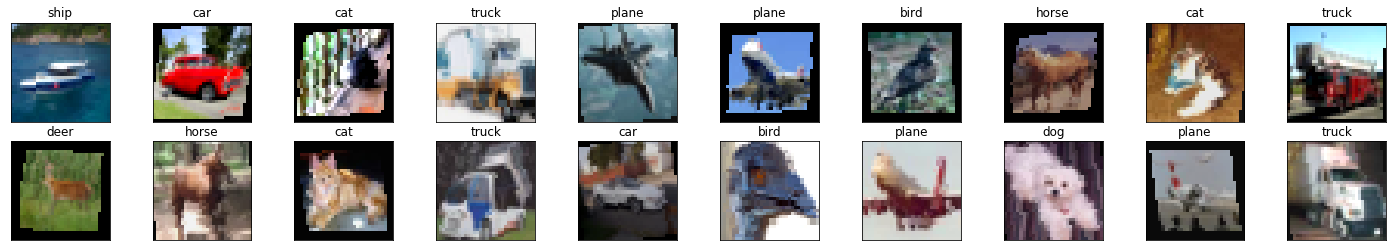

In [7]:
# Create object that allows iterable to run
dataiter = iter(training_loader)
images, labels = dataiter.next()
#images = images.to(device)
#labels = labels.to(device)
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[]) # plot 2 rows, 10 col per row, creating index per row
    plt.imshow(im_convert(images[idx]))
#    ax.set_title([labels[idx].item()])
    ax.set_title(classes[labels[idx].item()])

In [12]:
# Neural Network Implementation on Image Recog (S7 #7) - 09162020
class LeNet(nn.Module):
    def __init__(self): # n of input node, no. of nodes in 1st input layer, no. of nodes in 2nd input layer, no. of nodes in output layer
        super().__init__()
#        self.conv1 = nn.Conv2d(3, 20, 5, 1) # n input channel, n output, n kernel size, n stride length
#        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        # increasing out channel of conv network
        self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1) # include padding 
        self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1) # 3rd conv layer
        self.fc1 = nn.Linear(4*4*64, 500) # 4 * 4 * 50 ~ layer has 50 channels, each has a 4 * 4 dimension img, 500 nodes
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(500, 10) # output has 10 classes need to be classified, 500 img input
            
    def forward(self, X): 
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2) # X = feed forward value, 2 by 2 kernel
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 4*4*64) # n cols, n rows
        X = F.relu(self.fc1(X))
        X = self.dropout1(X)
        X = self.fc2(X)
        return X

In [13]:
# Continue 10/07/2020 (evening)
model = LeNet().to(device) # 28 px * 28 px = 784 pixels for MNIST(784 nodes necesary)
model

LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001) # tips, start with a high learning rate then adjust based on results whether loss fluctuates or not (skewness)

In [15]:
epochs = 15
running_loss_history = []
running_corrects_history = []
# validation running history
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
            
    running_loss = 0.0
    running_corrects = 0.0     
    val_running_loss = 0.0
    val_running_corrects = 0.0
    
    for inputs, labels in training_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        # remove flattening as we're inputting full dimensional layer of image
#        inputs = inputs.view(inputs.shape[0], -1)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            
        _, preds = torch.max(outputs, 1)

        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
        
    else:
        # save memory
        with torch.no_grad():
            for val_inputs, val_labels in validation_loader:
                # remove flattening as we're inputting full dimensional layer of image                
#                val_inputs = val_inputs.view(val_inputs.shape[0], -1)
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
            
                _, val_preds = torch.max(val_outputs, 1)
                val_running_loss += val_loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels.data)
        
        epoch_loss = running_loss / len(training_loader)
        epoch_acc = running_corrects.float() / len(training_loader)
        running_loss_history.append(epoch_loss)
        running_corrects_history.append(epoch_acc)
        
        val_epoch_loss = val_running_loss / len(validation_loader)
        val_epoch_acc = val_running_corrects.float() / len(validation_loader)
        val_running_loss_history.append(val_epoch_loss)
        val_running_corrects_history.append(val_epoch_acc)
        
        print("epoch: ", e+1)
    
        if(e == 14):
            print("Finished!")

        print("training loss: {:.4f}, training correct: {:.4f}".format(epoch_loss, epoch_acc.item()))
        print("validation loss: {:.4f}, validation correct: {:.4f}".format(val_epoch_loss, val_epoch_acc.item()))        

epoch:  1
training loss: 1.6775, training correct: 38.7840
validation loss: 1.3966, validation correct: 49.4500
epoch:  2
training loss: 1.3843, training correct: 50.3640
validation loss: 1.2733, validation correct: 54.4900
epoch:  3
training loss: 1.2516, training correct: 55.5560
validation loss: 1.1691, validation correct: 58.5800
epoch:  4
training loss: 1.1636, training correct: 58.6760
validation loss: 1.0597, validation correct: 62.6100
epoch:  5
training loss: 1.1009, training correct: 60.9960
validation loss: 1.0126, validation correct: 64.0700
epoch:  6
training loss: 1.0494, training correct: 62.8920
validation loss: 0.9841, validation correct: 65.3900
epoch:  7
training loss: 1.0195, training correct: 63.8740
validation loss: 0.9305, validation correct: 67.3600
epoch:  8
training loss: 0.9831, training correct: 65.4740
validation loss: 0.9089, validation correct: 68.3300
epoch:  9
training loss: 0.9591, training correct: 66.4600
validation loss: 0.9010, validation correct: 

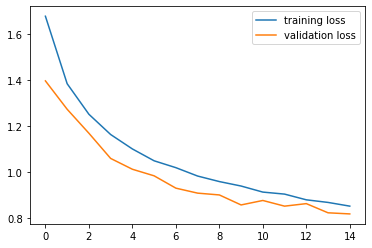

In [16]:
plt.plot(running_loss_history, label="training loss")
plt.plot(val_running_loss_history, label="validation loss")
plt.legend()
#plt.plot(running_corrects_history, label="training accuracy")

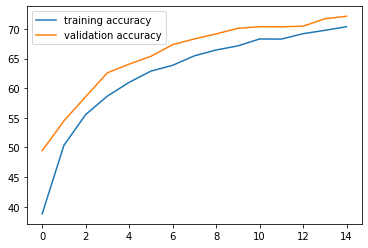

In [17]:
plt.plot(running_corrects_history, label="training accuracy")
plt.plot(val_running_corrects_history, label="validation accuracy")
plt.legend()

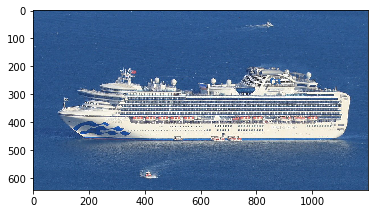

In [26]:
# Final tests (10152020)
import requests
import PIL.ImageOps
from PIL import Image
#url = 'https://img.kyodonews.net/english/public/images/posts/e2152cd92d5ad6f7759a08bdc7df47ad/image_l.jpeg'
url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/2/22/Diamond_Princess_%28ship%2C_2004%29_-_cropped.jpg/1200px-Diamond_Princess_%28ship%2C_2004%29_-_cropped.jpg'
#url = 'https://c.files.bbci.co.uk/12A9B/production/_111434467_gettyimages-1143489763.jpg'
#url = 'https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/dog-puppy-on-garden-royalty-free-image-1586966191.jpg?crop=1.00xw:0.669xh;0,0.190xh&resize=1200:*'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)
#print(response)

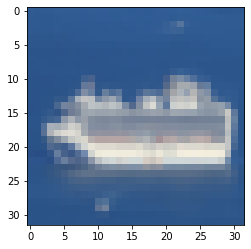

In [27]:
#img = PIL.ImageOps.invert(img)
#img = img.convert('1')
img = transform(img)
plt.imshow(im_convert(img))

In [28]:
# remove flattening
#img = img.view(img.shape[0], -1)
image = img.to(device).unsqueeze(0)
#image = img.to(device)
# remove unsqueezing of image
#image = images[0].unsqueeze(0).unsqueeze(0)

output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

ship


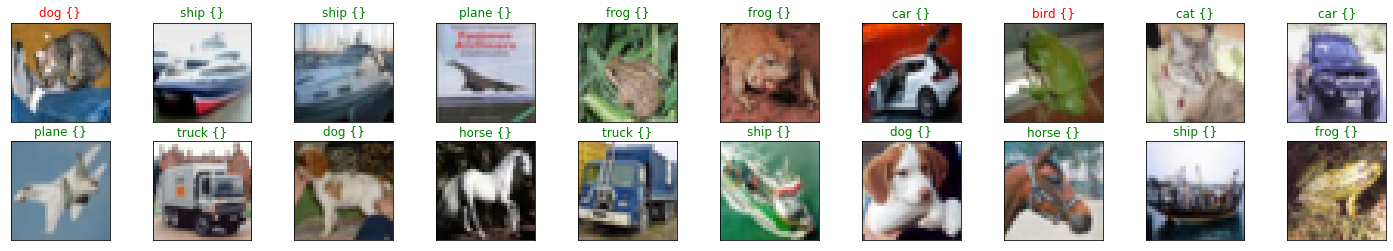

In [29]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
#images_ = images.view(images.shape[0], -1)
output = model(images)

_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[]) # plot 2 rows, 10 col per row, creating index per row
    plt.imshow(im_convert(images[idx]))
    ax.set_title("{} {{}}".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))